In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [11]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw_centered
from sliding_window_detector import SlidingWindowTransformerDetector, SlidingWindowLinearDetector, FineTunedSlidingWindowDetector, ConvolutionalSlidingWindowDetector

from data import CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

In [3]:
torch.set_grad_enabled(False)

In [4]:
test_width = 512
test_file = Path(f"../data/test_london_slidingWindow_{test_width}.pkl")
test_datasets = [
    # "australian_electricity_demand_dataset", # accuracy  ~0.95
    # "electricity_hourly_dataset", # accuracy ~0.976
    # "electricity_load_diagrams", # ~0.953
    # "HouseholdPowerConsumption1",
    # "HouseholdPowerConsumption2",
    "london_smart_meters_dataset_without_missing_values",
    # "solar_10_minutes_dataset",
    # "wind_farms_minutely_dataset_without_missing_values",
]

In [5]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [6]:
# validation
if not test_file.exists():
    val_data, val_weights = load_series(test_datasets, "VAL")
    val_gen = CenteredArtifactDataset(
        val_data,
        width=test_width,
        padding=64,
        artifact=Saw_centered(),
        weight=val_weights,
    )
    val = CachedArtifactDataset.generate(val_gen,
                                         n=2048,
                                         to=test_file)
else:
    val = CachedArtifactDataset(file=test_file)

In [7]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [12]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
cnn_only = ConvolutionalSlidingWindowDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=500.ckpt").cpu()

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
cnn_dense_635 = SlidingWindowLinearDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=48500-v1.ckpt").cpu()

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_587 = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=48000.ckpt").cpu()

# data_asset = ml_client.data.get("artifactory_output", version="48")
# artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
# transformer_ft = FineTunedSlidingWindowDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/earlystop/epoch=0-step=18500.ckpt").cpu()


Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/earlystop/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/earlystop/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Exa

In [13]:
def baseline_detector(input: torch.Tensor) -> int:   
    input.squeeze(0)
    prediction = 0

    center = int(input.shape[1]/2)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[0][1:] - input[0][:-1]).abs()
    mean_increment = torch.mean(increments)
    print(mean_increment)
    std_increment = torch.std(increments)
    print(std_increment)
    print(increments[center-1])

    if increments[center-1] > (mean_increment + 3*std_increment):
        prediction = 1
        print('yes')
    else:
        print('no')
    
    # # flag highest/lowest point as artifact
    # # or better also with mean/std?
    # absolute_values = input.abs()
    # if input[0][center-1] > absolute_values.sort()[-3]:
    #     prediction = 1

    return prediction

In [ ]:
preds_baseline = list()
gt = list()

for sample in val:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    example_data = torch.tensor(example + sample["artifact"])
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [sample["label"]]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_cnn_1 = list()
preds_cnn_2 = list()
preds_trans_1 = list()
#preds_trans_2 = list()
#preds_trans_ft = list()
preds_baseline = list()
gt = list()

for sample in val:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    prediction_cnn_1 = cnn_only(example_data.unsqueeze(0))   
    prediction_cnn_2 = cnn_dense_635(example_data.unsqueeze(0))
    prediction_trans_1 = transformer_587(example_data.unsqueeze(0))
    #prediction_trans_2 = transformer_671(example_data.unsqueeze(0))
    #prediction_trans_ft = transformer_ft(example_data.unsqueeze(0))
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))

    preds_cnn_1 = preds_cnn_1 + [prediction_cnn_1.numpy()]
    preds_cnn_2 = preds_cnn_2 + [prediction_cnn_2.numpy()]
    preds_trans_1 = preds_trans_1 + [prediction_trans_1.numpy()]
    #preds_trans_2 = preds_trans_2 + [prediction_trans_2.numpy()]
    #preds_trans_ft = preds_trans_ft + [prediction_trans_ft.numpy()]
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [sample["label"]]


tensor(0.3675)
tensor(0.6198)
tensor(0.5778)
no
tensor(0.3426)
tensor(1.3116)
tensor(0.1568)
no
tensor(0.4166)
tensor(1.3359)
tensor(0.0661)
no
tensor(0.4153)
tensor(0.7511)
tensor(0.0925)
no
tensor(0.4435)
tensor(0.7240)
tensor(0.0134)
no
tensor(0.4146)
tensor(1.0103)
tensor(0.6254)
no
tensor(0.5335)
tensor(1.1711)
tensor(1.4601)
no
tensor(0.3965)
tensor(0.8409)
tensor(1.8045)
no
tensor(0.5561)
tensor(0.6460)
tensor(1.5631)
no
tensor(0.5648)
tensor(0.8372)
tensor(0.4960)
no
tensor(0.3868)
tensor(0.8052)
tensor(6.3145)
yes
tensor(0.5206)
tensor(0.8588)
tensor(0.7448)
no
tensor(0.5108)
tensor(1.0984)
tensor(0.4891)
no
tensor(0.3074)
tensor(0.7218)
tensor(0.0145)
no
tensor(0.1937)
tensor(0.3171)
tensor(0.0070)
no
tensor(0.5065)
tensor(0.7035)
tensor(0.2697)
no
tensor(0.5735)
tensor(0.9254)
tensor(1.3996)
no
tensor(0.6100)
tensor(0.5701)
tensor(4.8811)
yes
tensor(0.4595)
tensor(0.7271)
tensor(0.0566)
no
tensor(0.4592)
tensor(0.7033)
tensor(0.1150)
no
tensor(0.5115)
tensor(0.9680)
tensor(6

tensor(0.5364)
tensor(0.9760)
tensor(0.1851)
no
tensor(0.6586)
tensor(0.9939)
tensor(9.7290)
yes
tensor(0.4808)
tensor(0.8982)
tensor(4.5255)
yes
tensor(0.5101)
tensor(0.9120)
tensor(0.2951)
no
tensor(0.3110)
tensor(0.6002)
tensor(6.2367)
yes
tensor(0.5238)
tensor(0.8132)
tensor(0.6086)
no
tensor(0.3365)
tensor(0.7844)
tensor(0.2770)
no
tensor(0.3662)
tensor(0.5501)
tensor(1.6198)
no
tensor(0.3200)
tensor(0.7047)
tensor(0.)
no
tensor(0.5744)
tensor(1.2741)
tensor(0.0115)
no
tensor(0.7047)
tensor(1.0199)
tensor(0.4651)
no
tensor(0.5960)
tensor(1.0464)
tensor(0.2384)
no
tensor(0.2574)
tensor(0.7099)
tensor(0.)
no
tensor(0.5394)
tensor(0.6860)
tensor(2.0640)
no
tensor(0.5994)
tensor(1.4359)
tensor(0.)
no
tensor(0.6034)
tensor(0.9523)
tensor(2.0065)
no
tensor(0.5353)
tensor(0.8217)
tensor(0.0282)
no
tensor(0.6206)
tensor(0.9823)
tensor(0.1975)
no
tensor(0.6355)
tensor(1.0945)
tensor(0.1817)
no
tensor(0.3737)
tensor(0.7411)
tensor(0.0861)
no
tensor(0.4728)
tensor(0.6871)
tensor(6.4430)
yes


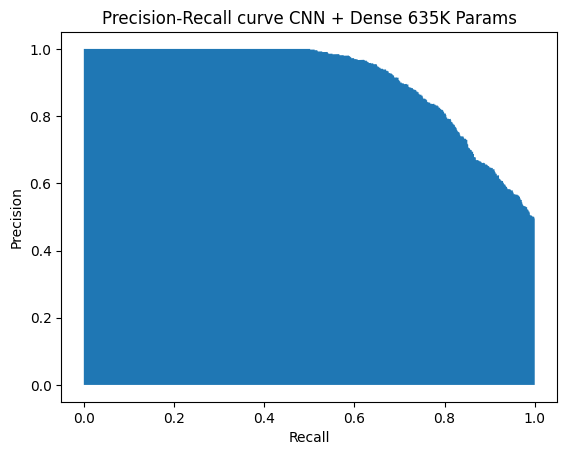

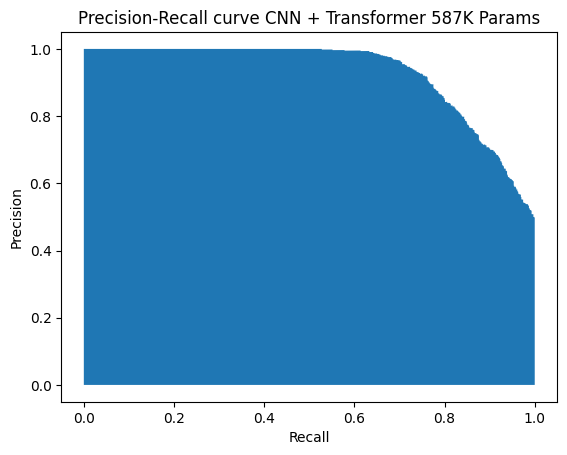

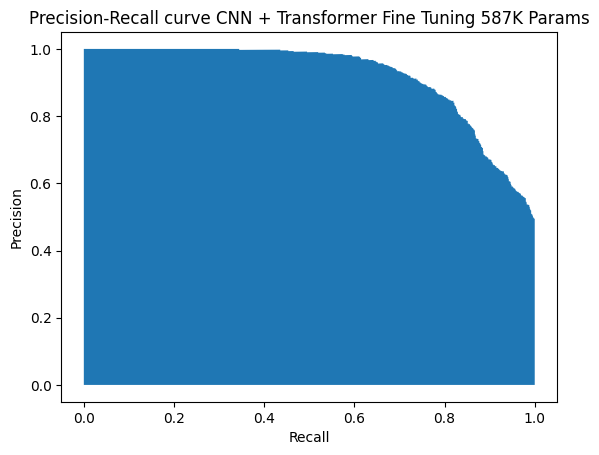

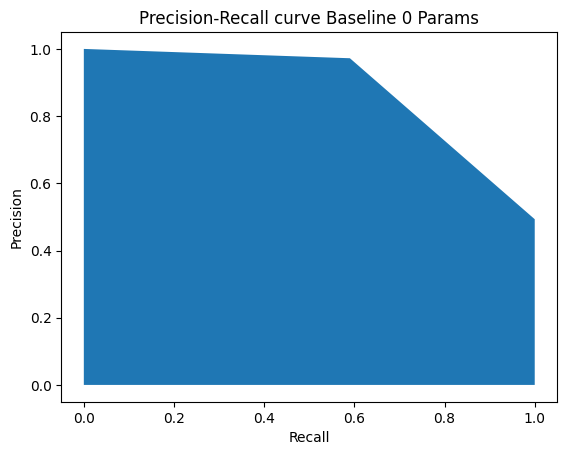

In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_cnn_1)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr_cnn1 = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Dense 635K Params")
plt.show()

# precision, recall, thresholds = precision_recall_curve(gt, preds_cnn_2)
# J = precision + recall
# ix = np.argmax(J)
# best_thresh_pr = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans_1)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Transformer 587K Params")
plt.show()

# precision, recall, thresholds = precision_recall_curve(gt, preds_trans_2)
# J = precision + recall
# ix = np.argmax(J)
# best_thresh_pr = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans_ft)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Transformer Fine Tuning 587K Params")
plt.show()

precision, recall, thresholds = precision_recall_curve(gt, preds_baseline)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve Baseline 0 Params")
plt.show()


In [15]:
from sklearn.metrics import fbeta_score

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_cnn_1 = np.where(preds_cnn_1 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_cnn_1, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_cnn_1 = threshold

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_cnn_2 = np.where(preds_cnn_2 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_cnn_2, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_cnn_2 = threshold


max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_trans_1 = np.where(preds_trans_1 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_trans_1, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_trans_1 = threshold

max_fbeta = 0

# for threshold in np.linspace(0,  1,  100):
#     predictions_trans_2 = np.where(preds_trans_2 > threshold, 1, 0)

#     fbeta = fbeta_score(gt, predictions_trans_2, average='macro', beta=0.5)

#     if (fbeta > max_fbeta):
#         max_fbeta = fbeta
#         best_threshold_fbeta_trans_2 = threshold

# max_fbeta = 0

# for threshold in np.linspace(0,  1,  100):
#     predictions_trans_ft = np.where(preds_trans_ft > threshold, 1, 0)

#     fbeta = fbeta_score(gt, predictions_trans_ft, average='macro', beta=0.5)

#     if (fbeta > max_fbeta):
#         max_fbeta = fbeta
#         best_threshold_fbeta_ft = threshold

# max_fbeta = 0


In [21]:
preds_binary_cnn_1 = [1 if value >= best_threshold_fbeta_cnn_1 else 0 for value in preds_cnn_1]
preds_binary_cnn_2 = [1 if value >= best_threshold_fbeta_cnn_2 else 0 for value in preds_cnn_2]
preds_binary_trans_1 = [1 if value >= best_threshold_fbeta_trans_1 else 0 for value in preds_trans_1]
#preds_binary_trans_2 = [1 if value >= best_threshold_fbeta_trans_2 else 0 for value in preds_trans_2]
#preds_binary_trans_ft = [1 if value >= best_threshold_fbeta_ft else 0 for value in preds_trans_ft]
preds_binary_baseline = preds_baseline

tn_cnn_1, fp_cnn_1, fn_cnn_1, tp_cnn_1 = confusion_matrix(gt, preds_binary_cnn_1, labels=[0, 1]).ravel()
tn_cnn_2, fp_cnn_2, fn_cnn_2, tp_cnn_2 = confusion_matrix(gt, preds_binary_cnn_2, labels=[0, 1]).ravel()
tn_trans_1, fp_trans_1, fn_trans_1, tp_trans_1 = confusion_matrix(gt, preds_binary_trans_1, labels=[0, 1]).ravel()
#tn_trans_2, fp_trans_2, fn_trans_2, tp_trans_2 = confusion_matrix(gt, preds_binary_trans_2, labels=[0, 1]).ravel()
#tn_trans_ft, fp_trans_ft, fn_trans_ft, tp_trans_ft = confusion_matrix(gt, preds_binary_trans_ft, labels=[0, 1]).ravel()
tn_baseline, fp_baseline, fn_baseline, tp_baseline = confusion_matrix(gt, preds_binary_baseline, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'cnn_only',
    'threshold': best_threshold_fbeta_cnn_1,
    'accuracy': accuracy_score(gt, preds_binary_cnn_1),
    'precision': precision_score(gt, preds_binary_cnn_1),
    'recall': recall_score(gt, preds_binary_cnn_1),
    'fbeta': fbeta_score(gt, preds_binary_cnn_1, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_cnn_1),
    'tn': tn_cnn_1,
    'fp': fp_cnn_1, 
    'fn': fn_cnn_1, 
    'tp': tp_cnn_1,
},
{
    'detector': 'cnn_dense_635K',
    'threshold': best_threshold_fbeta_cnn_2,
    'accuracy': accuracy_score(gt, preds_binary_cnn_2),
    'precision': precision_score(gt, preds_binary_cnn_2),
    'recall': recall_score(gt, preds_binary_cnn_2),
    'fbeta': fbeta_score(gt, preds_binary_cnn_2, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_cnn_2),
    'tn': tn_cnn_2,
    'fp': fp_cnn_2, 
    'fn': fn_cnn_2, 
    'tp': tp_cnn_2
},
{
    'detector': 'transformer_587K',
    'threshold': best_threshold_fbeta_trans_1,
    'accuracy': accuracy_score(gt, preds_binary_trans_1),
    'precision': precision_score(gt, preds_binary_trans_1),
    'recall': recall_score(gt, preds_binary_trans_1),
    'fbeta': fbeta_score(gt, preds_binary_trans_1, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_trans_1),
    'tn': tn_trans_1,
    'fp': fp_trans_1, 
    'fn': fn_trans_1, 
    'tp': tp_trans_1
},
# {
#     'detector': 'transformer_671K',
#     'threshold': best_threshold_fbeta_trans_2,
#     'accuracy': accuracy_score(gt, preds_binary_trans_2),
#     'precision': precision_score(gt, preds_binary_trans_2),
#     'recall': recall_score(gt, preds_binary_trans_2),
#     'mse': mean_squared_error(gt, preds_binary_trans_2),
#     'tn': tn_trans_2,
#     'fp': fp_trans_2, 
#     'fn': fn_trans_2, 
#     'tp': tp_trans_2
# },    
# {
#     'detector': 'ft_transformer_587K',
#     'threshold': best_threshold_fbeta_ft,
#     'accuracy': accuracy_score(gt, preds_binary_trans_ft),
#     'precision': precision_score(gt, preds_binary_trans_ft),
#     'recall': recall_score(gt, preds_binary_trans_ft),
#     'mse': mean_squared_error(gt, preds_binary_trans_ft),
#     'tn': tn_trans_ft,
#     'fp': fp_trans_ft, 
#     'fn': fn_trans_ft, 
#     'tp': tp_trans_ft
# },
{
    'detector': 'baseline',
    'threshold': 0.5,
    'accuracy': accuracy_score(gt, preds_binary_baseline),
    'precision': precision_score(gt, preds_binary_baseline),
    'recall': recall_score(gt, preds_binary_baseline),
    'fbeta': fbeta_score(gt, preds_binary_baseline, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_baseline),
    'tn': tn_baseline,
    'fp': fp_baseline, 
    'fn': fn_baseline, 
    'tp': tp_baseline
}])

/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
metrics

,detector,threshold,accuracy,precision,recall,fbeta,mse,tn,fp,fn,tp
0,cnn_only,0.565657,0.506836,0.000000,0.000000,0.000000,0.493164,1038,0,1010,0
1,cnn_dense_635K,0.343434,0.863281,0.928404,0.783168,0.895201,0.136719,977,61,219,791
2,transformer_587K,0.424242,0.850586,0.955959,0.730693,0.900439,0.149414,1004,34,272,738
3,baseline,0.500000,0.789551,0.972268,0.590099,0.860774,0.210449,1021,17,414,596


In [13]:
best_thresh_pr

0.48818028

In [ ]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [18]:
best_threshold_fbeta

0.5252525252525253

In [ ]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [20]:
df = pd.DataFrame({
    'index': range(len(val)),
    'gt': gt,
    'predictions': preds_binary
})

In [ ]:
# Create the bar plot
plt.hist(preds_trans, bins=10)

# Customize the plot (optional)
plt.title("Predictions on synthetic validation set")

# Display the plot
plt.show()

In [21]:
# get indices of samples
fp_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 1)])["index"]
fn_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 0)])["index"]
tn_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 0)])["index"]
tp_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 1)])["index"]

In [ ]:
import matplotlib

for index in tp_ind[10:20]:
    sample = val[int(index)]
    label = sample["label"]
    example = torch.tensor(sample["data"] + sample["artifact"])

    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    plt.figure(figsize=(10, 6.666))
    plt.plot(example, label="data", c="blue", linewidth=3.0)
    plt.axvline(x=256, c="red", linestyle="--", linewidth=3.0, dashes=(4,4), label="position of artifact")
    # changing the fontsize of yticks
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("#Time steps [a.u.]", fontsize=20)
    plt.ylabel("Power [a.u.]", fontsize=20)
    # to set the font size of the legend 
    # plt.title(f"Label: {label}, prediction: {prediction_trans}, sample number {int(index)}")
    #plt.title(f"Sliding Window detector, artifact in the middle: {label}")
    # to set the font size of the legend 
    matplotlib.rcParams['legend.fontsize'] = 15
    plt.legend(loc='best')
    plt.show()